## Load data

Import the required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import seaborn as sns

Load the data

In [3]:
dataset = pd.read_csv('salary-data.csv')
dataset.shape

(47502, 49)

In [4]:
dataset.head()

,Timestamp,Age Range,Years of Experience,Industry,Job Title,Company Name,Highest Level of Education Received,"Closest Major City and State (e.g. Santa Clara, CA)",Country,"Annual Base Salary (if hourly, please convert to annual)",...,.16,.17,.18,.19,.20,.21,.22,.23,.24,.25
0,12/5/2021 11:57:44,26-29,6,Healthcare,Registered Nurse,Penn Medicine,Bachelor's Degree,"Philadelphia, PA",US,"$85,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12/6/2021 19:31:11,30-33,13,Retail banking,Financial center manager,Bank of America,"Some College credit, no degree","San Diego, CA",USA,"$71,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12/6/2021 19:32:35,22-25,1,fintech,SDR,Blend,Bachelor's Degree,San Francisco California,Usa,"$97,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12/6/2021 19:34:44,22-25,2,Marketing/Data/Business,Associate Business System Analyst,Epsilon,Bachelor's Degree,"Dallas, TX",USA,"$57,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12/6/2021 19:39:17,22-25,1,Retail,Software Engineer,Target,Bachelor's Degree,"Minneapolis, MN",USA,"$80,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Select the required columns

In [5]:
selected_features = ['Age Range', 'Years of Experience', 'Industry', 'Job Title', 'Highest Level of Education Received', 'Country', 'Annual Base Salary (if hourly, please convert to annual)', 'Gender (optional)', 'Closest Major City and State (e.g. Santa Clara, CA)', 'Company Name']

dataset = dataset[selected_features]

dataset.shape

(47502, 10)

Rename the columns

In [6]:
column_name_mapping = {
    'Age Range': 'age_range',
    'Years of Experience': 'years_experience',
    'Industry': 'industry',
    'Job Title': 'job_title',
    'Highest Level of Education Received': 'education_level',
    'Country': 'country',
    'Annual Base Salary (if hourly, please convert to annual)': 'annual_salary',
    'Currency (USD, CAD, etc)': 'currency',
    'Gender (optional)': 'gender',
    'Closest Major City and State (e.g. Santa Clara, CA)': 'state',
    'Company Name': 'company_name',
}

dataset.rename(columns=column_name_mapping, inplace=True)

Clean salary column

In [7]:
dataset['annual_salary'] = dataset['annual_salary'].str.replace(r'[^\d.]+', '', regex=True)
dataset['annual_salary'] = pd.to_numeric(dataset['annual_salary'], errors='coerce')
dataset.loc[dataset['annual_salary'] < 300, 'annual_salary'] *= 1000
dataset = dataset[dataset['annual_salary'] <= 950000]
mean_salary = dataset[dataset['annual_salary'] > 0]['annual_salary'].mean()
dataset.loc[dataset['annual_salary'] == 0, 'annual_salary'] = mean_salary

Leave only number values for 'years_experience' column, as '20+' is too generalized

In [8]:
dataset = dataset[dataset['years_experience'] != '20+']
dataset['years_experience'] = dataset['years_experience'].astype(float)
dataset.shape

(45047, 10)

Fill NA with mose frequent values for some categorical features

In [9]:
most_frequent_gender = dataset['gender'].mode()[0]
dataset['gender'].fillna(most_frequent_gender, inplace=True)

most_frequent_industry = dataset['industry'].mode()[0]
dataset['industry'].fillna(most_frequent_industry, inplace=True)

most_frequent_education_level = dataset['education_level'].mode()[0]
dataset['education_level'].fillna(most_frequent_education_level, inplace=True)

most_frequent_state = dataset['state'].mode()[0]
dataset['state'].fillna(most_frequent_state, inplace=True)

mean_experience = dataset['years_experience'].mean()
dataset['years_experience'].fillna(mean_experience, inplace=True)

/var/folders/zk/hk5mr31s5pg1yzs4p1dtycyw0000gn/T/ipykernel_76124/2112820448.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['gender'].fillna(most_frequent_gender, inplace=True)
/var/folders/zk/hk5mr31s5pg1yzs4p1dtycyw0000gn/T/ipykernel_76124/2112820448.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

Drop rows containing NA values

In [10]:
dataset = dataset.dropna()

Filter rows that contain too few values for categorical features grouped by value (for example: if we have job titles contained in 1000, 2000, 3000 ,etc number of rows, we can drop job titles that are contained in only 1, 2, 3, ..., 10 number of rows)

In [11]:
age_range_counts = dataset['company_name'].value_counts()
selected_age_ranges = age_range_counts[age_range_counts >= 10].index
dataset = dataset[dataset['company_name'].isin(selected_age_ranges)]

age_range_counts = dataset['job_title'].value_counts()
selected_age_ranges = age_range_counts[age_range_counts >= 1].index
dataset = dataset[dataset['job_title'].isin(selected_age_ranges)]

age_range_counts = dataset['country'].value_counts()
selected_age_ranges = age_range_counts[age_range_counts >= 10].index
dataset = dataset[dataset['country'].isin(selected_age_ranges)]

age_range_counts = dataset['state'].value_counts()
selected_age_ranges = age_range_counts[age_range_counts >= 6].index
dataset = dataset[dataset['state'].isin(selected_age_ranges)]

age_range_counts = dataset['industry'].value_counts()
selected_age_ranges = age_range_counts[age_range_counts >= 20].index
dataset = dataset[dataset['industry'].isin(selected_age_ranges)]

age_range_counts = dataset['years_experience'].value_counts()
selected_age_ranges = age_range_counts[age_range_counts >= 30].index
dataset = dataset[dataset['years_experience'].isin(selected_age_ranges)]

## Histograms

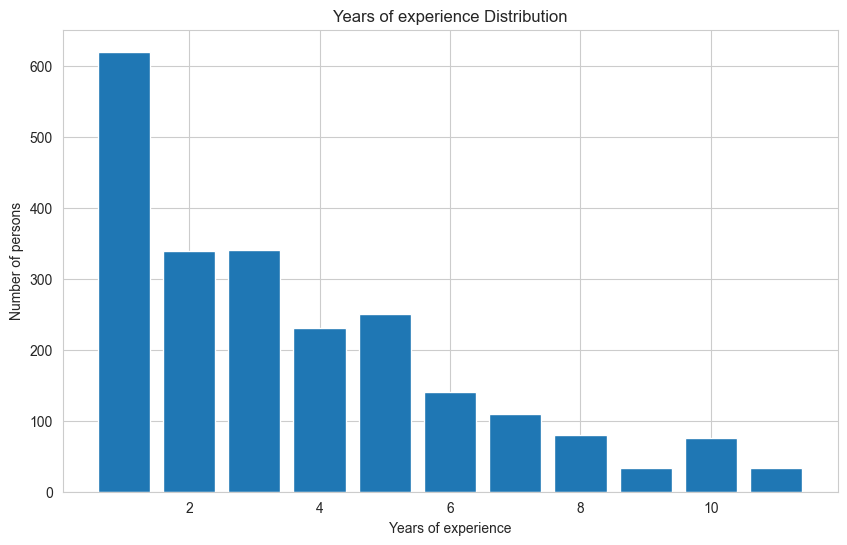

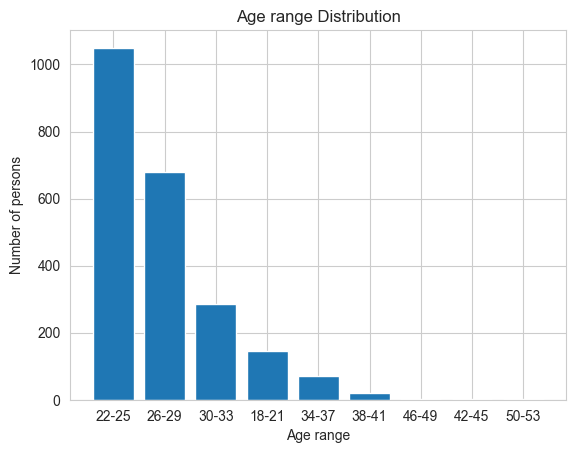

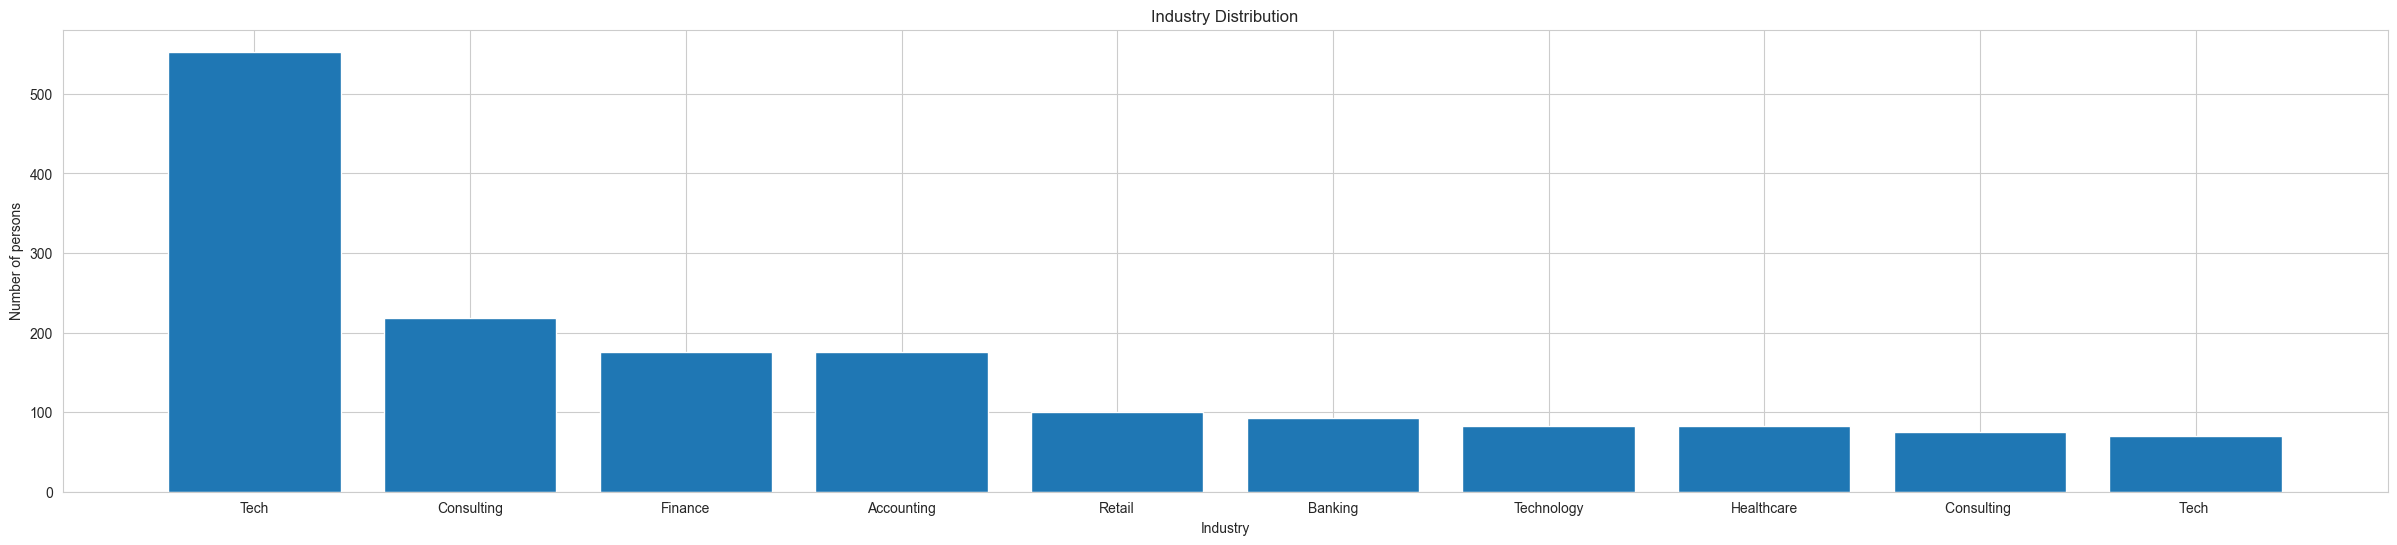

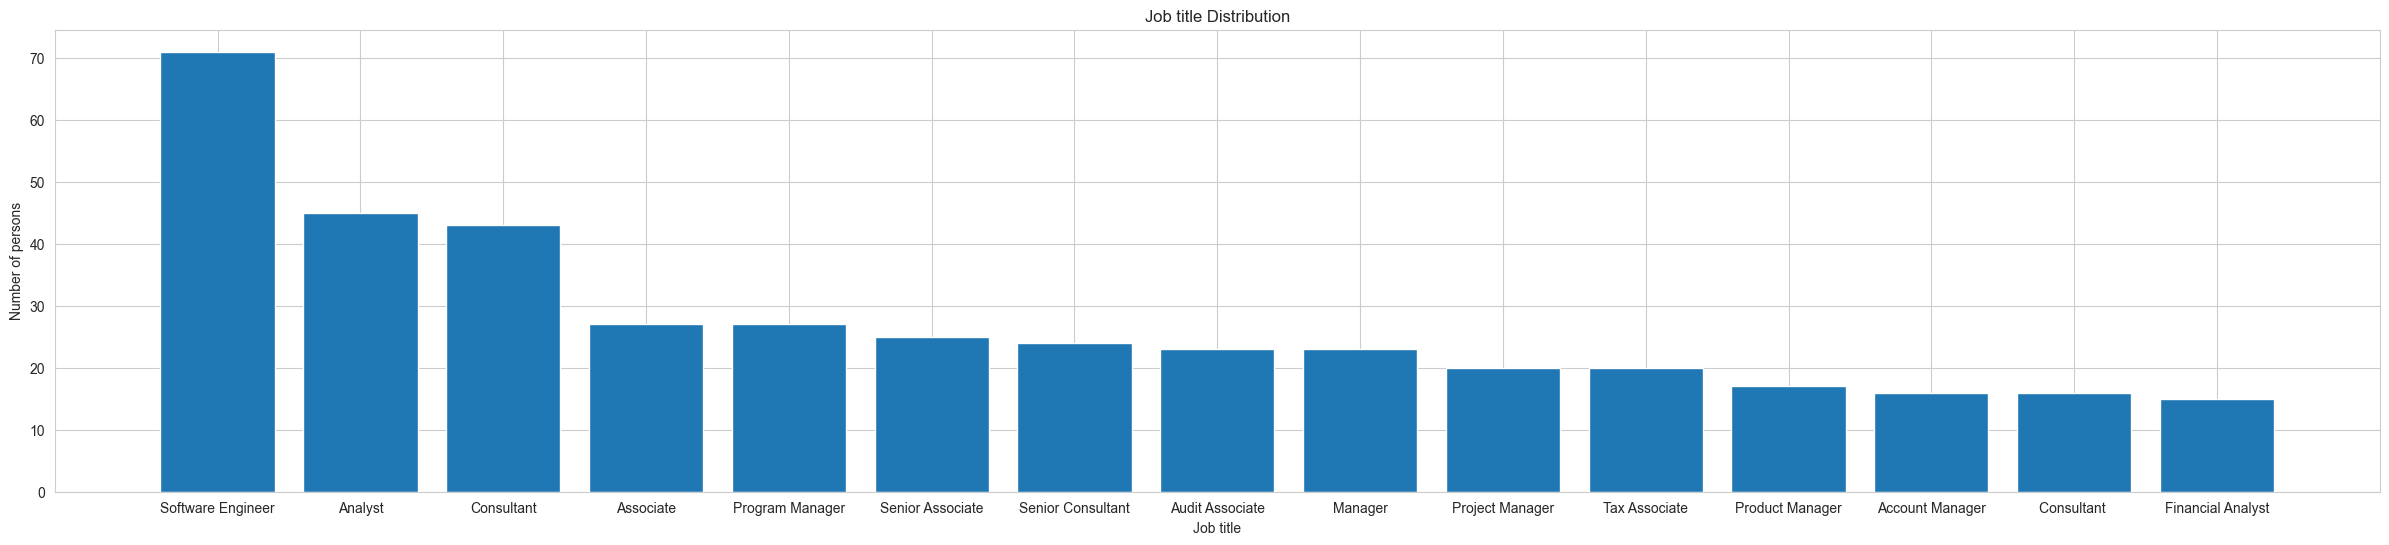

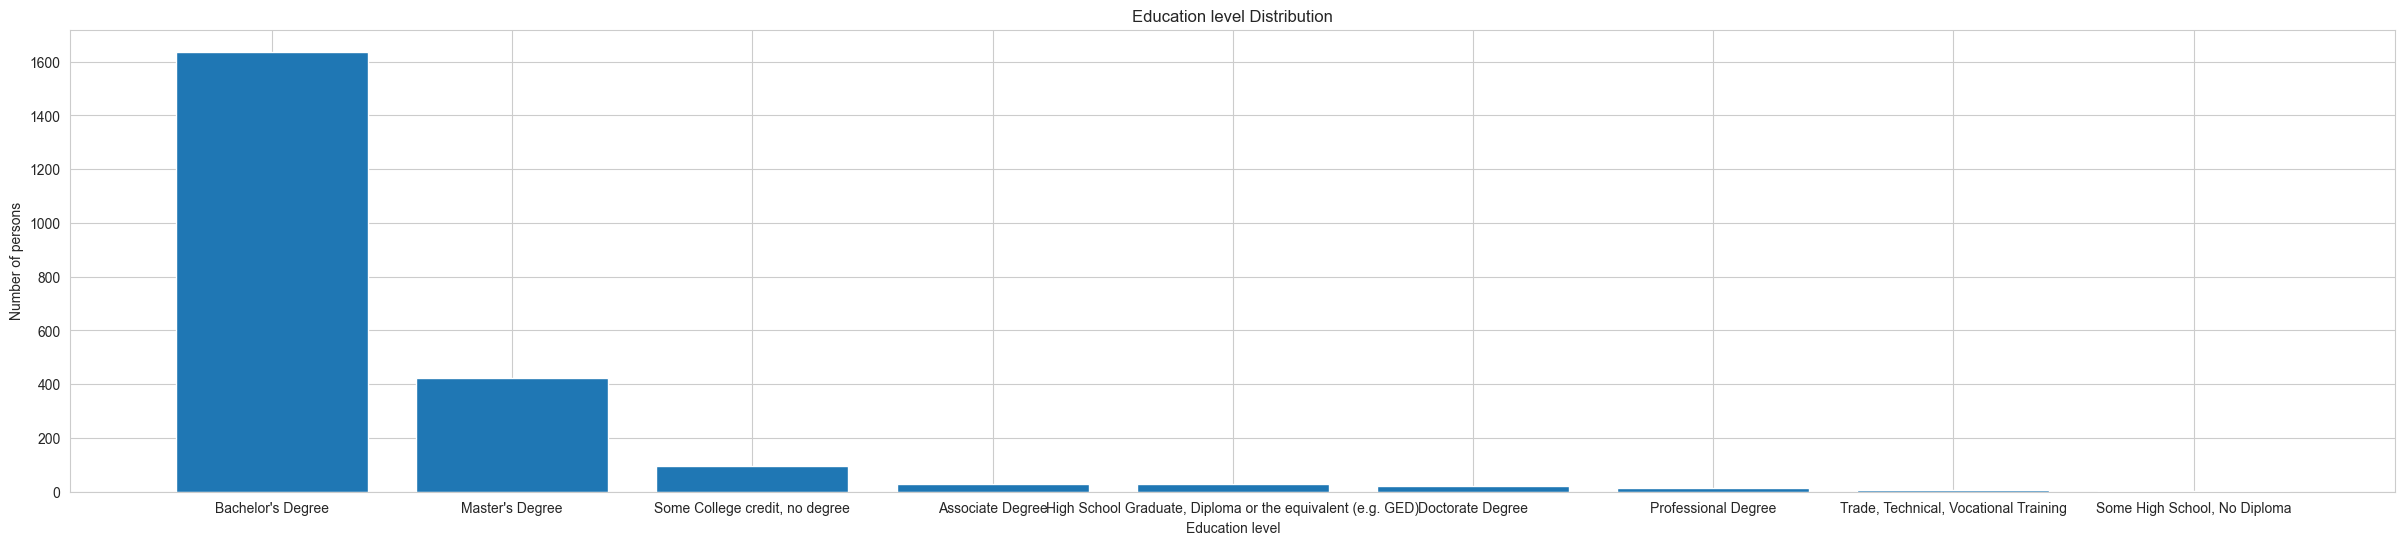

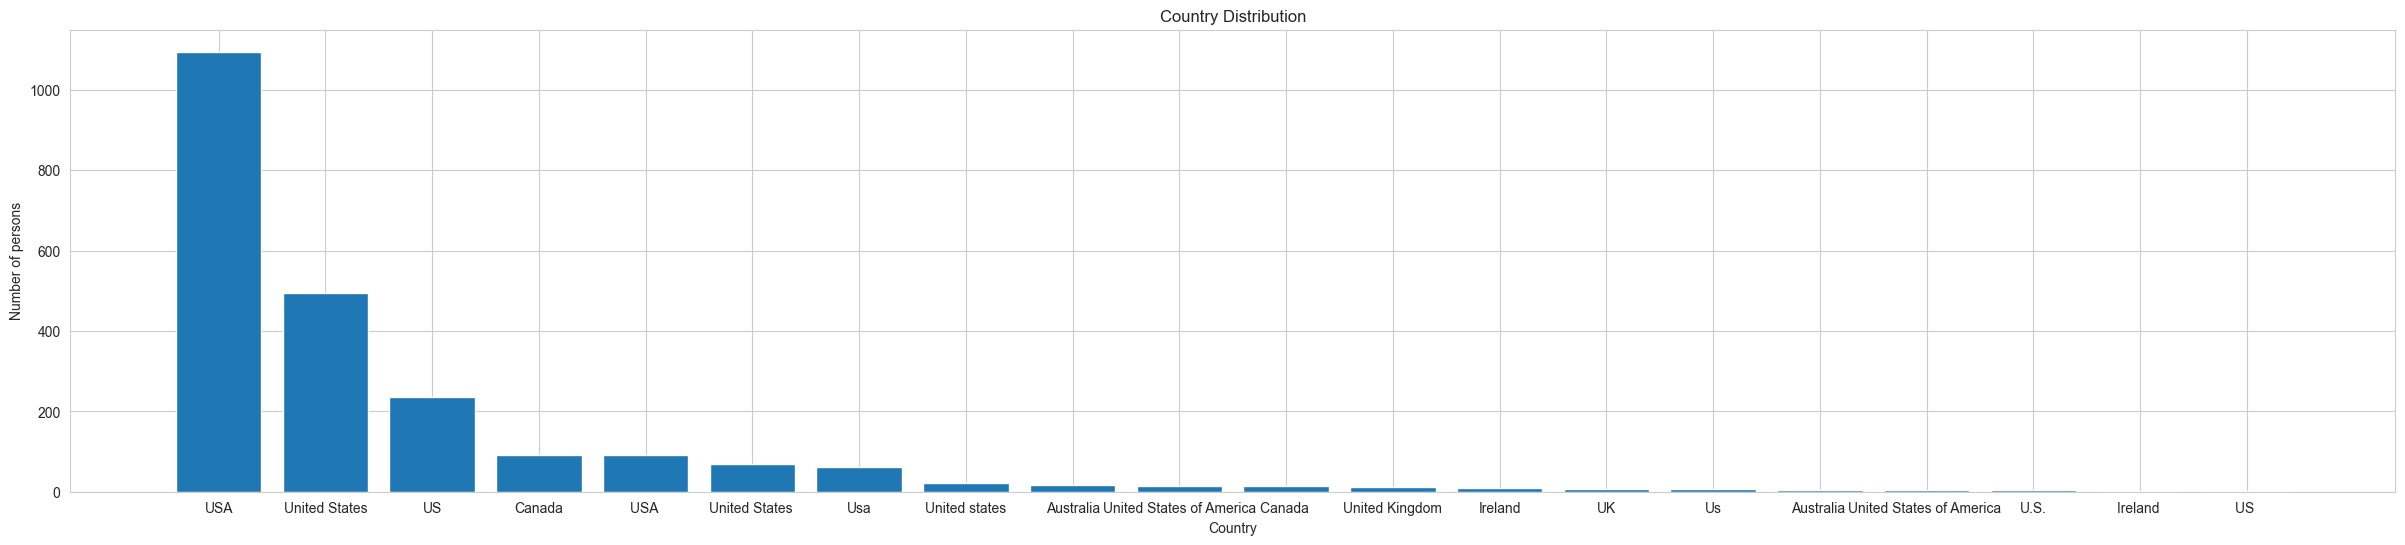

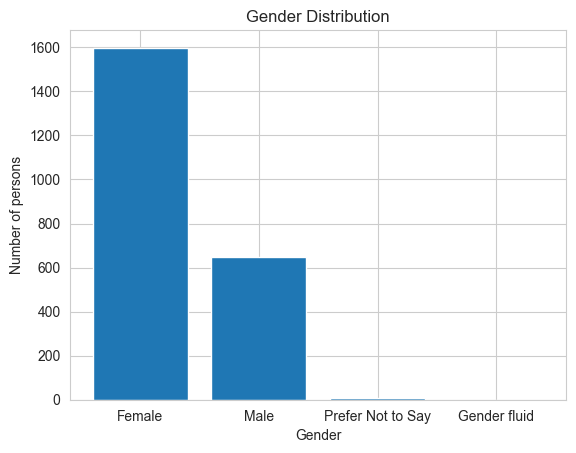

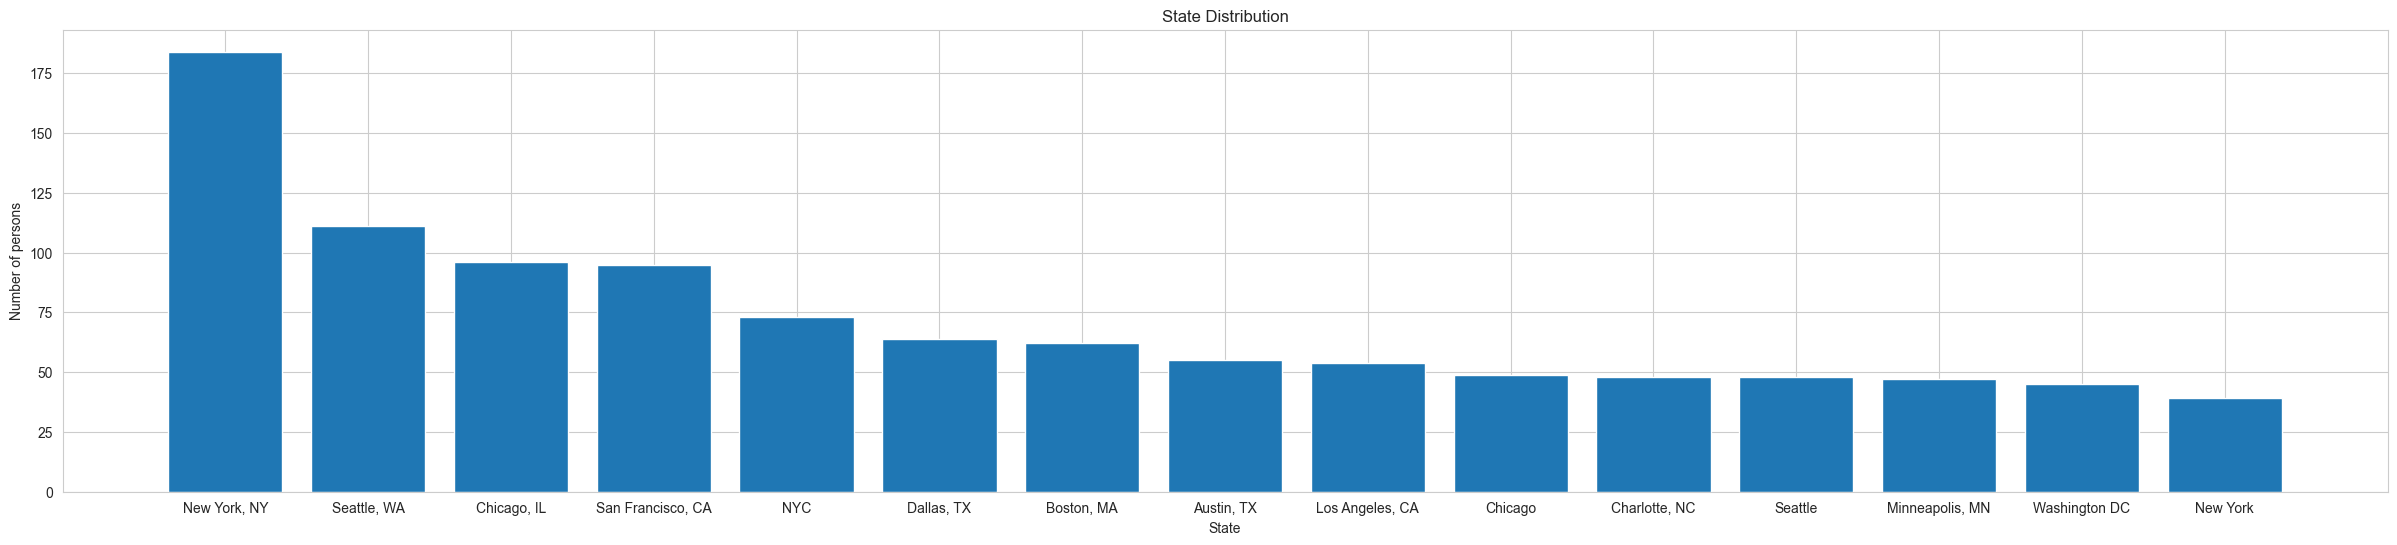

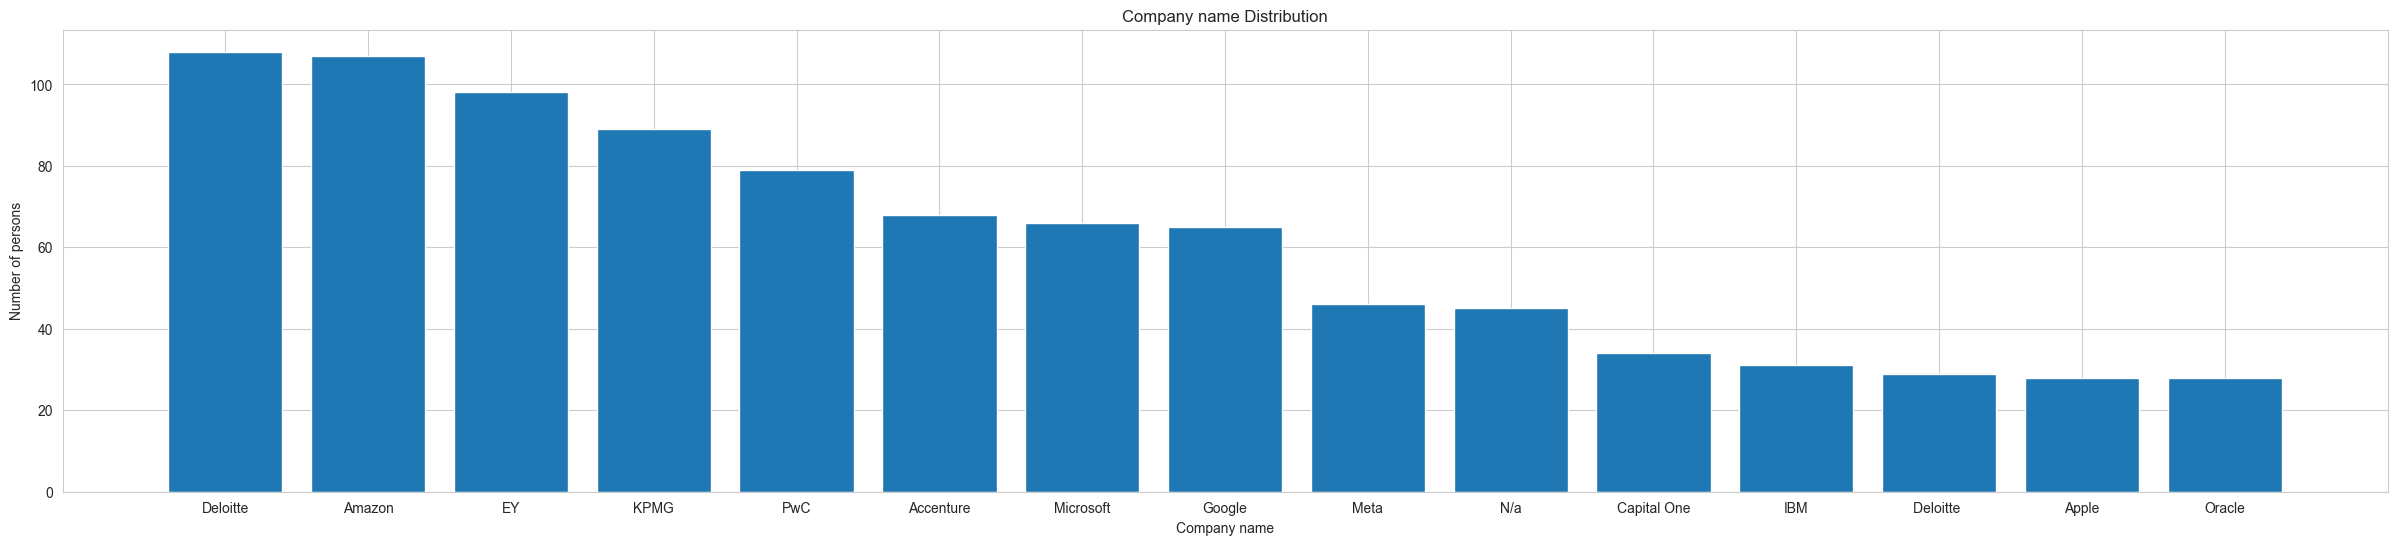

In [12]:
years_experience_counts = dataset['years_experience'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(years_experience_counts.index, years_experience_counts)
plt.xlabel('Years of experience')
plt.ylabel('Number of persons')
plt.title('Years of experience Distribution')
plt.show()

age_range_counts = dataset['age_range'].value_counts()
plt.bar(age_range_counts.index, age_range_counts)
plt.xlabel('Age range')
plt.ylabel('Number of persons')
plt.title('Age range Distribution')
plt.show()

country_counts = dataset['industry'].value_counts().head(10)
plt.figure(figsize=(30, 6))
plt.bar(country_counts.index, country_counts)
plt.xlabel('Industry')
plt.ylabel('Number of persons')
plt.title('Industry Distribution')
plt.show()

country_counts = dataset['job_title'].value_counts().head(15)
plt.figure(figsize=(30, 6))
plt.bar(country_counts.index, country_counts)
plt.xlabel('Job title')
plt.ylabel('Number of persons')
plt.title('Job title Distribution')
plt.show()

education_level_counts = dataset['education_level'].value_counts()
plt.figure(figsize=(30, 6))
plt.bar(education_level_counts.index, education_level_counts)
plt.xlabel('Education level')
plt.ylabel('Number of persons')
plt.title('Education level Distribution')
plt.show()

country_counts = dataset['country'].value_counts()
plt.figure(figsize=(30, 6))
plt.bar(country_counts.index, country_counts)
plt.xlabel('Country')
plt.ylabel('Number of persons')
plt.title('Country Distribution')
plt.show()

gender_counts = dataset['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts)
plt.xlabel('Gender')
plt.ylabel('Number of persons')
plt.title('Gender Distribution')
plt.show()

annual_salary_counts = dataset['state'].value_counts().head(15)
plt.figure(figsize=(30, 6))
plt.bar(annual_salary_counts.index, annual_salary_counts)
plt.xlabel('State')
plt.ylabel('Number of persons')
plt.title('State Distribution')
plt.show()

company_name_counts = dataset['company_name'].value_counts().head(15)
plt.figure(figsize=(30, 6))
plt.bar(company_name_counts.index, company_name_counts)
plt.xlabel('Company name')
plt.ylabel('Number of persons')
plt.title('Company name Distribution')
plt.show()

## Boxplots

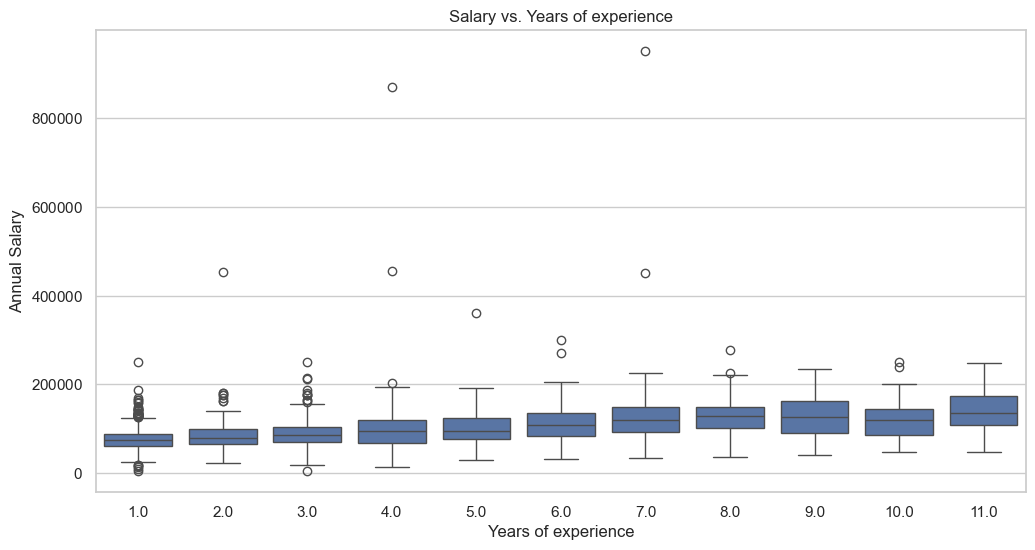

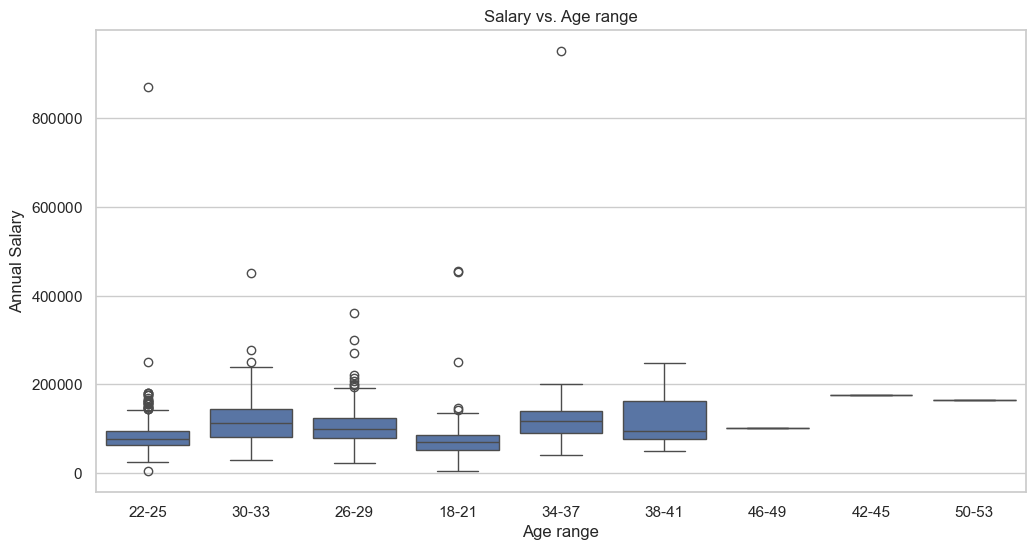

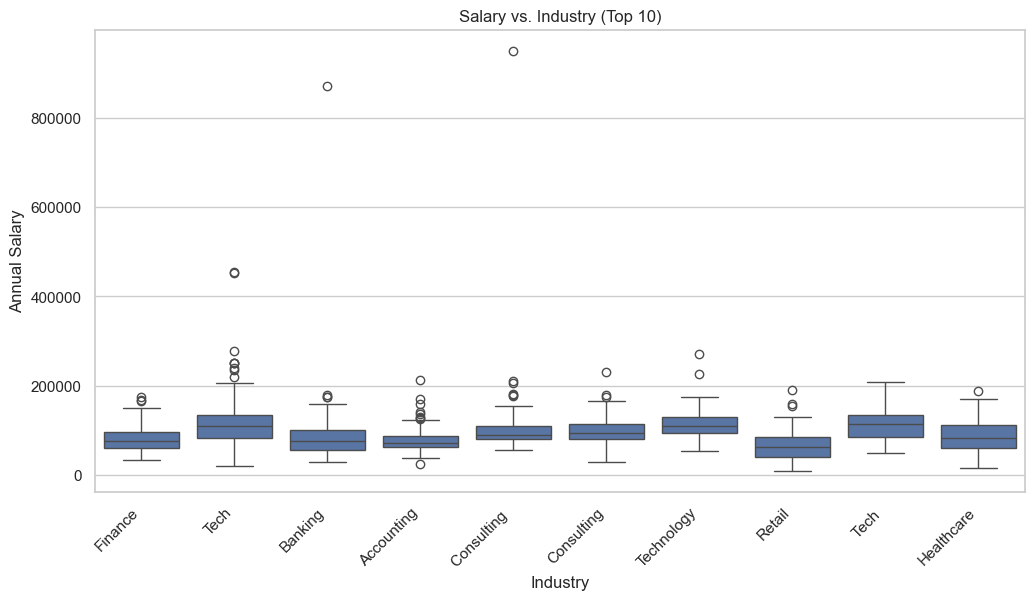

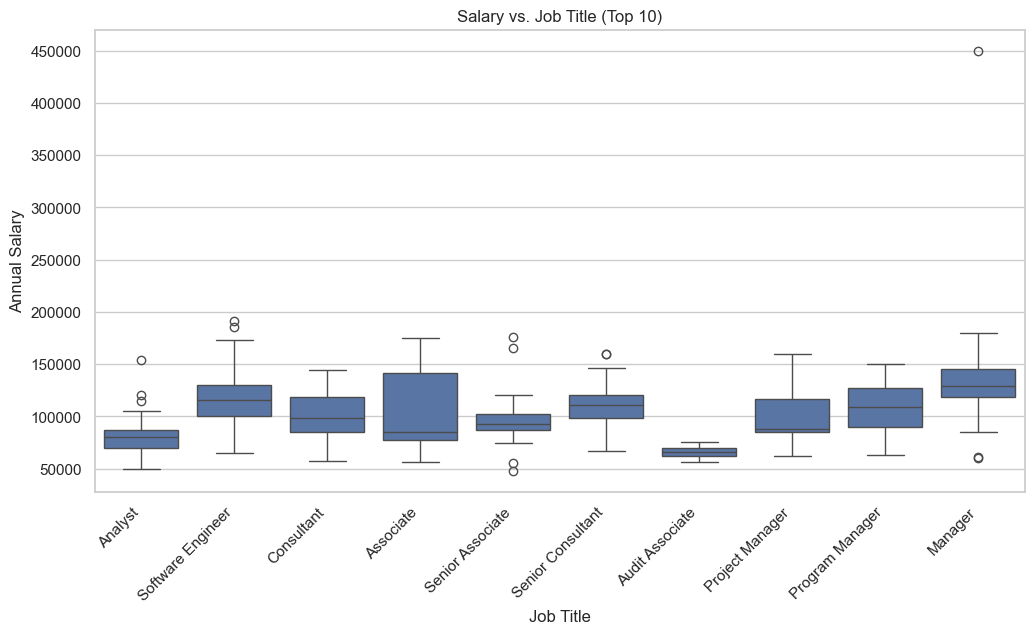

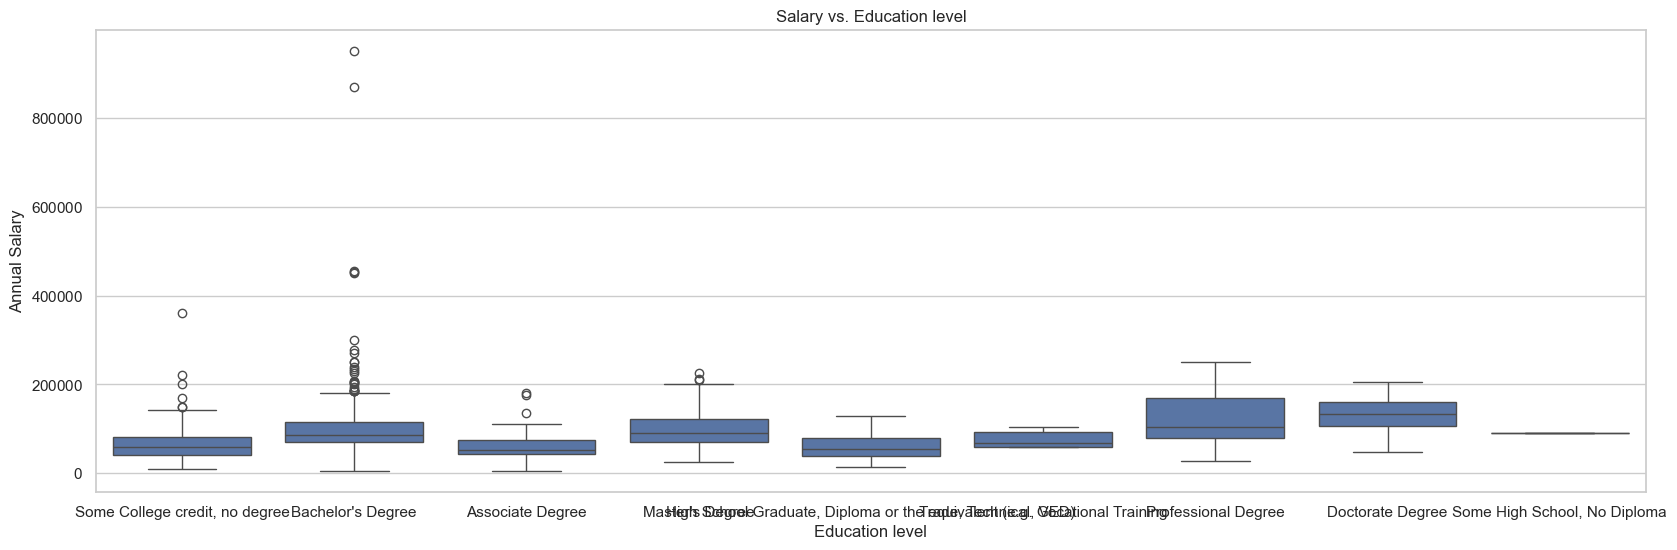

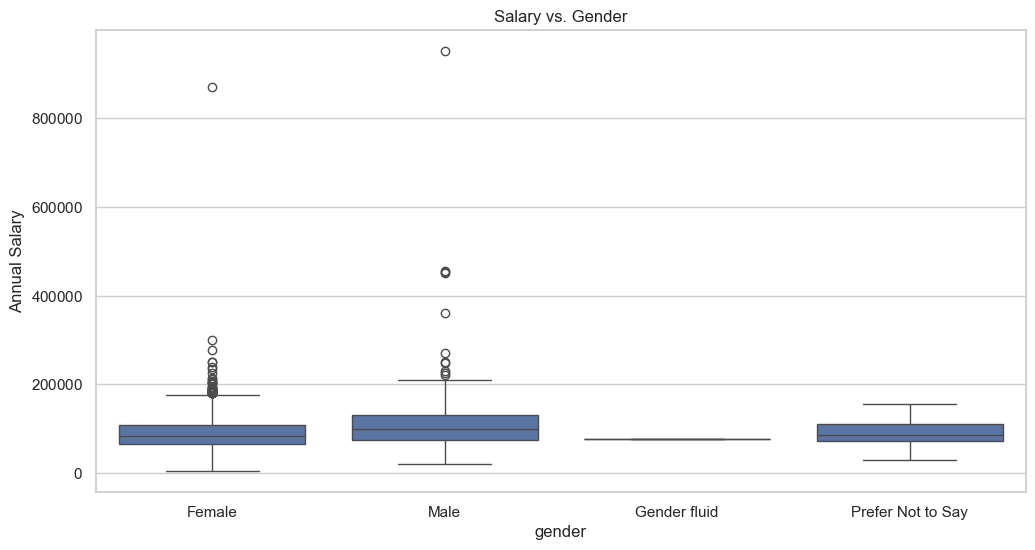

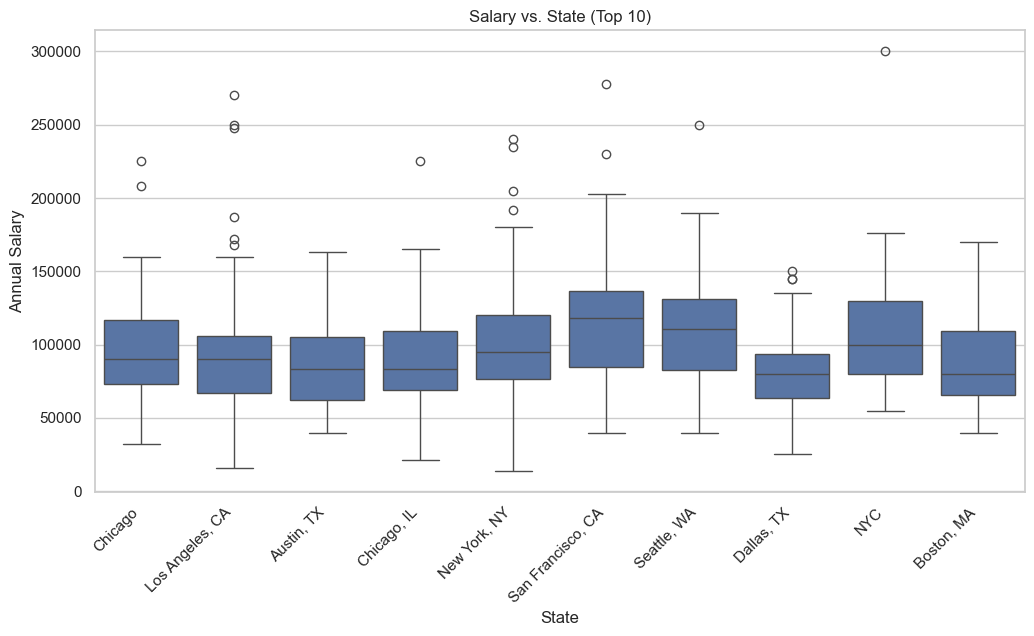

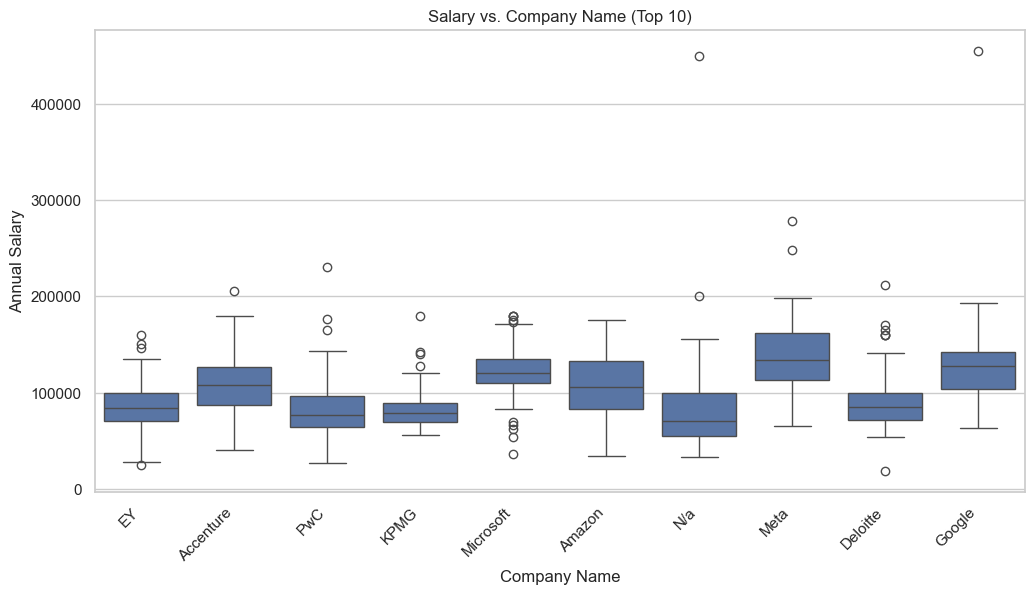

In [13]:
from matplotlib.ticker import ScalarFormatter

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x='years_experience', y='annual_salary', data=dataset)
plt.title('Salary vs. Years of experience')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.ylabel('Annual Salary')
plt.xlabel('Years of experience')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='age_range', y='annual_salary', data=dataset)
plt.title('Salary vs. Age range')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.ylabel('Annual Salary')
plt.xlabel('Age range')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

top_10_industries = dataset['industry'].value_counts().head(10).index
top_10_data = dataset[dataset['industry'].isin(top_10_industries)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='industry', y='annual_salary', data=top_10_data)
plt.title('Salary vs. Industry (Top 10)')
plt.xlabel('Industry')
plt.ylabel('Annual Salary')
plt.xticks(rotation=45, ha='right')
plt.show()

top_10_jobs = dataset['job_title'].value_counts().head(10).index
top_10_data = dataset[dataset['job_title'].isin(top_10_jobs)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='job_title', y='annual_salary', data=top_10_data)
plt.title('Salary vs. Job Title (Top 10)')
plt.xlabel('Job Title')
plt.ylabel('Annual Salary')
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(20, 6))
sns.boxplot(x='education_level', y='annual_salary', data=dataset)
plt.title('Salary vs. Education level')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.ylabel('Annual Salary')
plt.xlabel('Education level')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='annual_salary', data=dataset)
plt.title('Salary vs. Gender')
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)
plt.ylabel('Annual Salary')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

top_10_states = dataset['state'].value_counts().head(10).index
top_10_data = dataset[dataset['state'].isin(top_10_states)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='annual_salary', data=top_10_data)
plt.title('Salary vs. State (Top 10)')
plt.xlabel('State')
plt.ylabel('Annual Salary')
plt.xticks(rotation=45, ha='right')
plt.show()

top_10_companies = dataset['company_name'].value_counts().head(10).index
top_10_data = dataset[dataset['company_name'].isin(top_10_companies)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='company_name', y='annual_salary', data=top_10_data)
plt.title('Salary vs. Company Name (Top 10)')
plt.xlabel('Company Name')
plt.ylabel('Annual Salary')
plt.xticks(rotation=45, ha='right')
plt.show()

## Encoding categorical features

Encode categorical features using the mean annual salary as the value

In [14]:
mean_target_encoding = dataset.groupby('state')['annual_salary'].mean()
dataset['state_mean_target'] = dataset['state'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('age_range')['annual_salary'].mean()
dataset['age_range_mean_target'] = dataset['age_range'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('years_experience')['annual_salary'].mean()
dataset['years_experience_mean_target'] = dataset['years_experience'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('job_title')['annual_salary'].mean()
dataset['job_title_mean_target'] = dataset['job_title'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('company_name')['annual_salary'].mean()
dataset['company_name_mean_target'] = dataset['company_name'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('education_level')['annual_salary'].mean()
dataset['education_level_mean_target'] = dataset['education_level'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('gender')['annual_salary'].mean()
dataset['gender_mean_target'] = dataset['gender'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('country')['annual_salary'].mean()
dataset['country_mean_target'] = dataset['country'].map(mean_target_encoding)

mean_target_encoding = dataset.groupby('industry')['annual_salary'].mean()
dataset['industry_mean_target'] = dataset['industry'].map(mean_target_encoding)

## Model summary and Heatmap

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1578.
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:16:37   Log-Likelihood:                -25171.
No. Observations:                2254   AIC:                         5.036e+04
Df Residuals:                    2244   BIC:                         5.042e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Axes: >

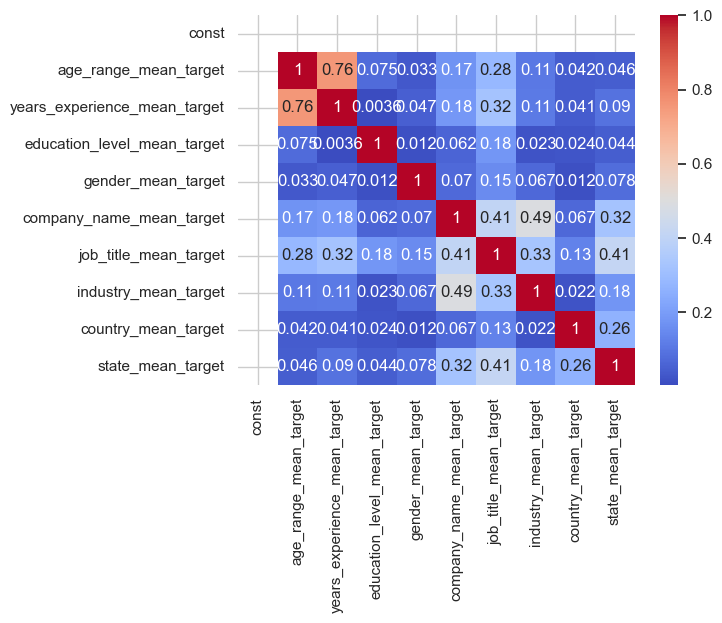

In [15]:
selected_columns = ['age_range_mean_target', 'years_experience_mean_target', 'education_level_mean_target', 'gender_mean_target', 'company_name_mean_target', 'job_title_mean_target', 'industry_mean_target', 'country_mean_target', 'state_mean_target', 'annual_salary']
dataset_copy = dataset[selected_columns].copy()

X = dataset_copy[['age_range_mean_target', 'years_experience_mean_target', 'education_level_mean_target', 'gender_mean_target', 'company_name_mean_target', 'job_title_mean_target', 'industry_mean_target', 'country_mean_target', 'state_mean_target']]
y = dataset_copy['annual_salary']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
correlation_matrix = X.corr()

print(model.summary())

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

Drop industry column due to high P value (normal is around 0.05)

In [16]:
dataset = dataset.drop('industry', axis=1)
dataset = dataset.drop('industry_mean_target', axis=1)

Drop years of experience due to multi-collinearity with age range column

In [17]:
dataset = dataset.drop('years_experience', axis=1)
dataset = dataset.drop('years_experience_mean_target', axis=1)

Drop state and company name due to multi-collinearity with job title column

In [18]:
dataset = dataset.drop('state', axis=1)
dataset = dataset.drop('state_mean_target', axis=1)

dataset = dataset.drop('company_name', axis=1)
dataset = dataset.drop('company_name_mean_target', axis=1)

New stats:

                            OLS Regression Results                            
Dep. Variable:          annual_salary   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     2515.
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:16:37   Log-Likelihood:                -25290.
No. Observations:                2254   AIC:                         5.059e+04
Df Residuals:                    2248   BIC:                         5.063e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

<Axes: >

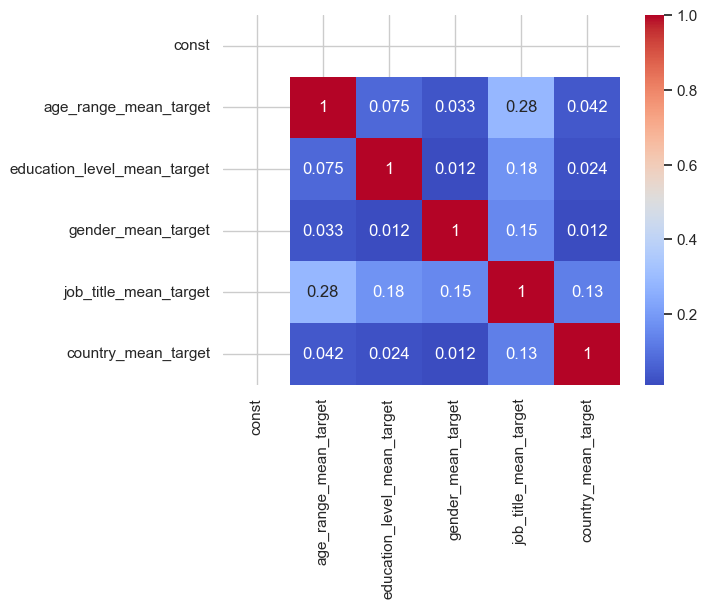

In [19]:
selected_columns = ['age_range_mean_target', 'education_level_mean_target', 'gender_mean_target', 'job_title_mean_target', 'country_mean_target', 'annual_salary']
dataset_copy = dataset[selected_columns].copy()

X = dataset_copy[['age_range_mean_target', 'education_level_mean_target', 'gender_mean_target', 'job_title_mean_target', 'country_mean_target']]
y = dataset_copy['annual_salary']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
correlation_matrix = X.corr()

print(model.summary())

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

## Train and predict

In [20]:
X = dataset[['age_range_mean_target', 'education_level_mean_target', 'gender_mean_target', 'job_title_mean_target']]
y = dataset['annual_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = {
    'Linear Regression': LinearRegression(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'SGDRegressor': SGDRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    mse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred) * 100
    print(f'R-squared: {r2}')
    print(f'MSE: {mse}')
    print('=====')

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

comparison_df['Difference'] = abs(comparison_df['Actual'] - comparison_df['Predicted'])

average_difference = comparison_df['Difference'].mean()

R-squared: 94.84070488827683
MSE: 14976.613952375727
=====
R-squared: 71.85458541477243
MSE: 34980.19895536776
=====
R-squared: 94.82494322870542
MSE: 14999.473303533883
=====


Choose SGDRegressor as it performed the best, boosting the hyperparameters

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

param_dist = {
    'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [50, 100, 150, 200, 250, 300, 450, 400, 500, 550],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
}

sgd_regressor = SGDRegressor()

random_search = RandomizedSearchCV(sgd_regressor, param_distributions=param_dist, scoring='neg_mean_squared_error', n_iter=10, cv=5, random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print(f'Best Hyperparameters: {best_params}')

best_sgd_model = random_search.best_estimator_
best_sgd_model.fit(X_train, y_train)

y_pred = best_sgd_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred) * 100
print(f'R-squared: {r2}')
print(f'RMSE: {rmse}')


Best Hyperparameters: {'max_iter': 200, 'learning_rate': 'invscaling', 'alpha': 0.0001}
R-squared: 94.83226289185686
RMSE: 14988.861831348355


/Users/artur/PycharmProjects/salary-prediction-model/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/artur/PycharmProjects/salary-prediction-model/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/artur/PycharmProjects/salary-prediction-model/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/artur/PycharmProjects/salary-prediction-model/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1575: ConvergenceWarning: Maximu

In some cases hyperparameter boosting improves a little bit the model

## Example of predictions

In [22]:
X = dataset[['age_range_mean_target', 'education_level_mean_target', 'gender_mean_target', 'job_title_mean_target']]
y = dataset['annual_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = SGDRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

print(comparison_df)

         Actual      Predicted
43652   74000.0   56328.731081
28330   77000.0   74071.077136
44670  104000.0  100516.408740
12143  101000.0   97179.366518
9666    66600.0   73825.597076
...         ...            ...
40875   83000.0   92905.468547
8882   112000.0   96848.413289
7906    92000.0   67357.757007
2536    58500.0   56328.731081
42309   95000.0   98568.107334

[451 rows x 2 columns]
